<a href="https://colab.research.google.com/github/martinsphl/MAI5035/blob/main/TAREFA_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAI5035: Task 1.1 by Paulo Martins and Vitória Barbosa

## Importing Main Libraries

In [1]:
# Main libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms

# Preprocess data: standardization and normalization
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

# Avoiding warning messages
import warnings
warnings.filterwarnings('ignore')

# Setting a global seed
np.random.seed(7)

## Data Gathering

We created a github public repository to upload the csv dataset and do software versioning. From github public url, we load the data into a pandas dataframe.

In [2]:
# Defining the url of each dataset
dataset_url = 'https://raw.githubusercontent.com/martinsphl/MAI5035/refs/heads/main/Steel_industry_data_task01.csv'

# Creating pandas dataframe from each dataset
df = pd.read_csv(dataset_url, names=['date', 'Usage_kWh',	'Lagging_Current_Reactive.Power_kVarh',	'Leading_Current_Reactive_Power_kVarh',	'CO2(tCO2)',	'Lagging_Current_Power_Factor',	'Leading_Current_Power_Factor',	'NSM',	'WeekStatus',	'Day_of_week',	'Load_Type',	'id'], skiprows=1, delimiter=',')


In [3]:
# Just checking that the dataframe was loaded correctly from the Github URL
print(df.head(5).to_markdown())

|    | date             |   Usage_kWh |   Lagging_Current_Reactive.Power_kVarh |   Leading_Current_Reactive_Power_kVarh |   CO2(tCO2) |   Lagging_Current_Power_Factor |   Leading_Current_Power_Factor |   NSM | WeekStatus   | Day_of_week   | Load_Type   |   id |
|---:|:-----------------|------------:|---------------------------------------:|---------------------------------------:|------------:|-------------------------------:|-------------------------------:|------:|:-------------|:--------------|:------------|-----:|
|  0 | 01/01/2018 00:15 |    -1571.8  |                                   2.95 |                                      0 |           0 |                          73.21 |                            100 |   nan | Weekday      | Monday        | Light_Load  | 6819 |
|  1 | 01/01/2018 00:30 |        4    |                                   4.46 |                                    nan |           0 |                          66.77 |                            100 |  1800 | Week

## Data Exploration

On this stage, we will get knowlodge on data. So, we'll check the type of columns and how many null values there are; since this point, all next exploratory analysis will be under numerics columns: check descriptive statistics, density distribution and outliers occurrences by IQR.

In [4]:
# Checking the data type of each column and if there are missing values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  31429 non-null  object 
 1   Usage_kWh                             31641 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  31514 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  31559 non-null  float64
 4   CO2(tCO2)                             31421 non-null  float64
 5   Lagging_Current_Power_Factor          31553 non-null  float64
 6   Leading_Current_Power_Factor          31488 non-null  float64
 7   NSM                                   31556 non-null  float64
 8   WeekStatus                            31586 non-null  object 
 9   Day_of_week                           31422 non-null  object 
 10  Load_Type                             31419 non-null  object 
 11  id             

In [5]:
# Checking the Descriptive Statistics of numerics columns
print(df.describe())

          Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
count  31641.000000                          31514.000000   
mean    -131.002346                             13.041851   
std      478.871597                             16.307235   
min    -1571.800000                              0.000000   
25%        3.020000                              2.300000   
50%        4.000000                              5.000000   
75%       47.410000                             22.640000   
max      157.180000                             96.910000   

       Leading_Current_Reactive_Power_kVarh     CO2(tCO2)  \
count                          31559.000000  31421.000000   
mean                               3.880215      0.011519   
std                                7.427221      0.016151   
min                                0.000000      0.000000   
25%                                0.000000      0.000000   
50%                                0.000000      0.000000   
75%                    

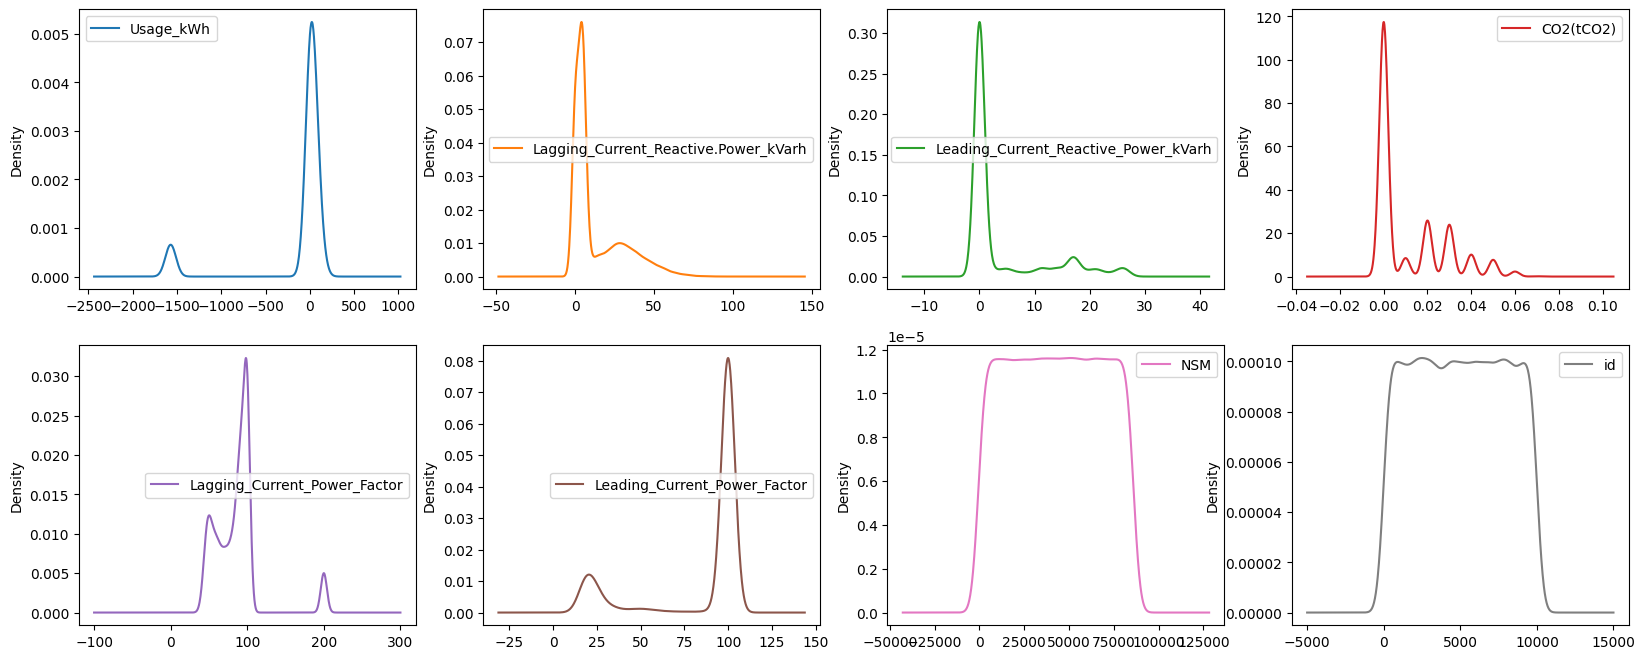

In [6]:
# Now let's check the density distribution of numeric columns
df.plot(kind = 'density', subplots = True, layout = (2,4), sharex = False, figsize = (20, 8))
plt.show()


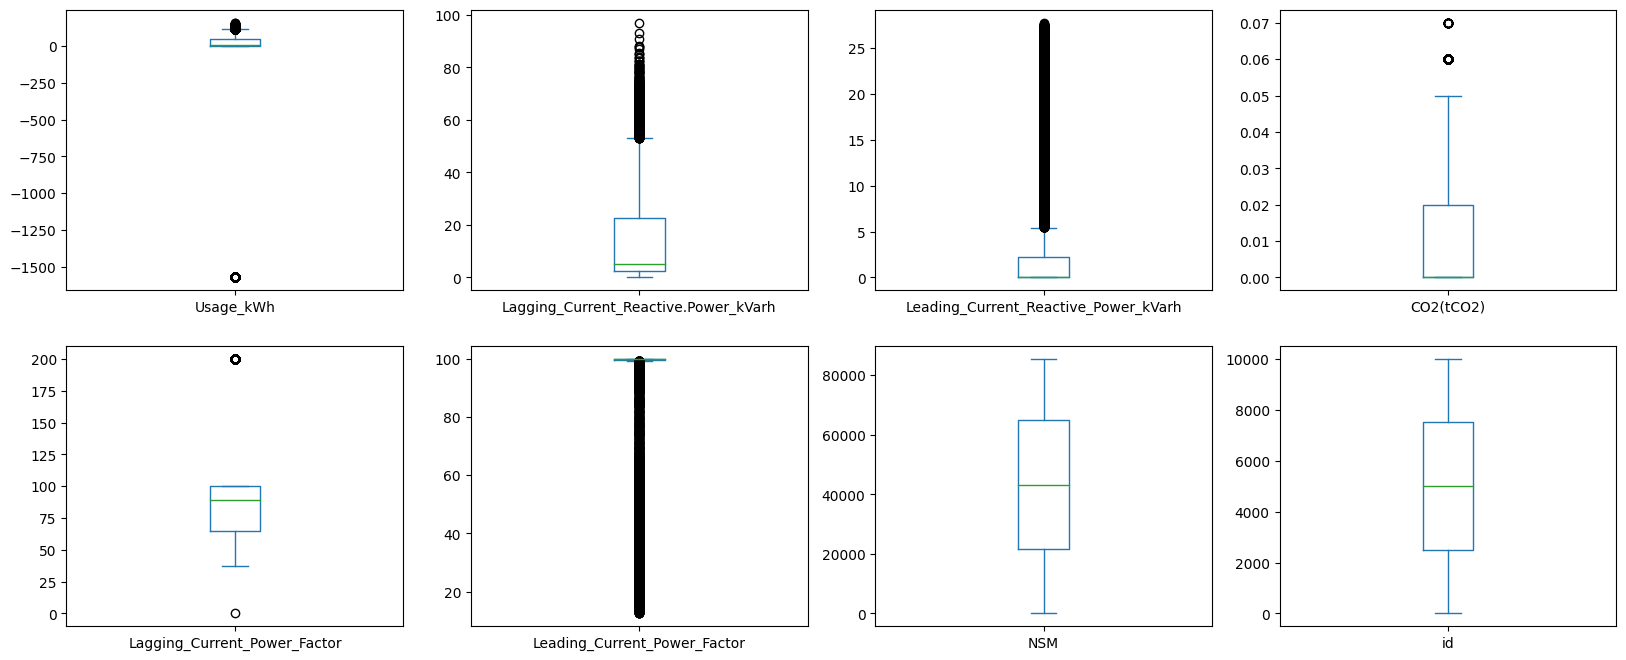

In [7]:
# Finally verifying if there is any outlier values based on IQR technique
df.plot(kind = 'box', subplots = True, layout = (2,4), sharex = False, sharey = False, figsize = (20,8))
plt.show()

We'd expect to see many outliers for some columns that have the following aspects
1. high standard deviation;
2. many missing values;
3. domain problems, such as negative consumption.

Once we have an overall understanding of the data, it's time to clean it up.

## Data Cleansing
This chapter is to preprocess the data before applying any machine learning algorithm. Therefore, we will detect outlier and null values to replace those for estimated value.

### Replace Outlier Values

The outlier values increase the noise in the data. It's difficult task finding out what it'd be the correct signal value. On many times this task is impossible to discovery.

Based on dataset documentation, we can assume that all numeric columns should be greater or equal to zero. In this solution version, we'll apply the following heuristic:

1.   Filtering (negative values) Or (values > avg + 1.5 x std) Or (values < avg - 1.5 x std)
2.   Replace this noise for NaN (null) value
3.   Apply a weighted average to estimate the new value

This section is about the items 1 e 2. The next section is for item 3.

According the official dataset documentation, the id column there are random values and, as you saw, there isn't any missing value. So we'll apply data cleansing process only for others numeric columns, just the float64 ones.



In [8]:
# Float64 column indexes are from 1 up to 7
list_indices = range(1,8)
print("Removing domain noise on float64 columns: ")
for i in list_indices:
    print(f"\t({i}/7) Starting with {df.columns[i]}")
    # Negative value mask
    negative_value = df.iloc[:, i] < 0

    # IQR Range mask
    q3 = df.iloc[:, i].quantile(0.75)
    q1 = df.iloc[:, i].quantile(0.25)
    iqr = q3 - q1
    iqr_sup_lim = df.iloc[:, i] > (q3 + 1.5 * iqr)
    iqr_inf_lim = df.iloc[:, i] < (q1 - 1.5 * iqr)

    # Main mask
    mask = negative_value | iqr_sup_lim | iqr_inf_lim
    df.iloc[mask, i] = np.nan # replace by Not a Number value

Removing domain noise on float64 columns: 
	(1/7) Starting with Usage_kWh
	(2/7) Starting with Lagging_Current_Reactive.Power_kVarh
	(3/7) Starting with Leading_Current_Reactive_Power_kVarh
	(4/7) Starting with CO2(tCO2)
	(5/7) Starting with Lagging_Current_Power_Factor
	(6/7) Starting with Leading_Current_Power_Factor
	(7/7) Starting with NSM


### Replace Missing Values

This section is about replace missing values from the raw data and also replace NaN values from outlier detection heuristic. The goal is all columns have 35040 non-null values, except the target one (which will be fill by KNN algorithm).

Total of rows 35040


<Axes: >

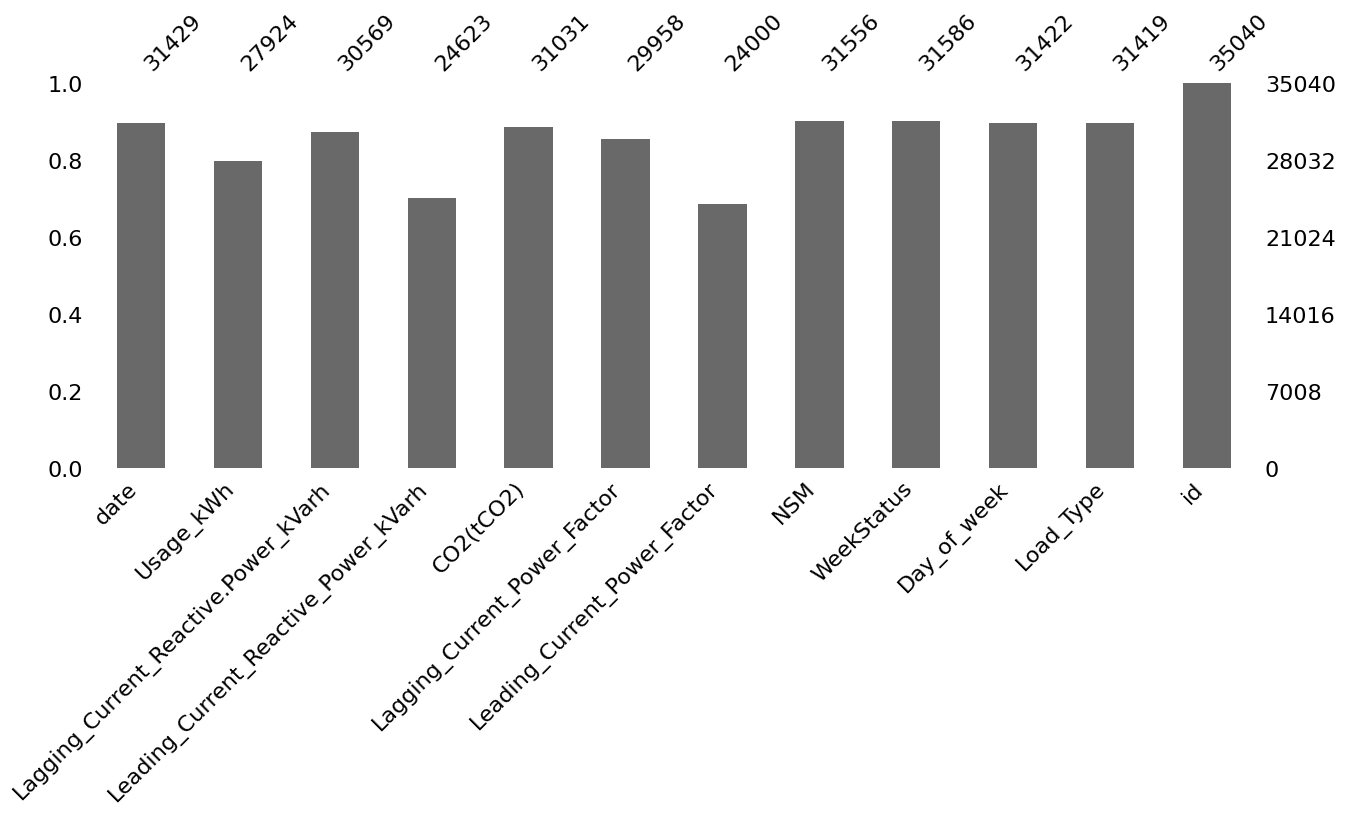

In [9]:
# Visualizing how many missing values there are
print(f"Total of rows {df.shape[0]}")
ms.bar(df, figsize=(15,5))

As you can see above, the total number of rows is 35040 (index) and the only column that is completely filled is the id column. Therefore we need to apply some techniques to replace missing values.

Before filling in the missing values column by column, let's check if there are any duplicate rows

In [10]:
# Looking for duplicate rows
grouped_df = df.groupby(list(df.columns)).size().reset_index(name='count_occurrences')
print(f"The maximum number of occurrences of row: {grouped_df.count_occurrences.max()}")
grouped_df = None

The maximum number of occurrences of row: 1


#### Date Column

Now it's time to analyze column by column, starting with the date. We can easily see that the cadence of the date column is 15 minutes. So, to fill in the missing values, we will check the value of the previous column and the next column to decide on the new value

In [11]:
# Change the column type to be able to apply some arithmetic to this column
df['date'] = pd.to_datetime(df['date'], format="%d/%m/%Y %H:%M", errors='coerce')

# Fill missing values based on the previous filled value
while df['date'].isnull().any():
    df['date'].fillna(df['date'].shift() + pd.Timedelta(minutes=15), inplace=True)

# Check how many missing values there are in the column date
print(f"Total missing values: {df[df.date.isna()].shape[0]}")

Total missing values: 0


#### Numeric Columns

As mentioned at the beginning of this chapter, there are no missing values in the id column (int64). For the other numeric columns (float64), we must fill in the missing values using some strategy.

In this version, we have opted for these steps as a solution:

1.   Remove Missing Values of the next steps
2.   Take the median value of the same day
3.   Take the median value of the same hour over the days
4.   Calculate the weighted average of the previous values and use it to fill in the missing values. We decided for: (6 x day median + 4 x hour median)/10

The decision to use the median is due to the fact that its value is robust in relation to outliers and, finally, we are using the mean to obtain a central value between the two.


In [ ]:
# Feature engineering: create some columns to support the strategy above
df['only_date'] = df.date.dt.date
df['hour'] = df.date.dt.hour

# Replace Missing Values Strategy
df['day_median'] = 0
df['hour_median'] = 0

# Float64 column indexes are from 1 up to 7
list_indices = range(1,8)
print("It can spend up to 5 minutes:")
for i in list_indices:
  print(f"\t({i}/7) Starting with {df.columns[i]}")
  # Step 1: Remove Missing Values of the next steps
  not_null = df.iloc[:, i].notna()

  for date in df.only_date.unique():
    # Step 2: Take the median value of the same day
    same_day = df.only_date == date
    # Getting the median value of the day
    mask = (not_null) & (same_day)
    pd_series = df[mask].iloc[:, i]
    # Mask for Missing Values
    missing_values = df.iloc[:, i].isna()
    mask = (missing_values) & (same_day)
    df.loc[mask, 'day_median'] =  pd_series.median()

    for hour in df.hour.unique():
      # Step 3: Take the median value of the same hour over the days
      same_hour = df.hour == hour
      # Getting the median value of the day
      mask = (not_null) & (same_hour)
      pd_series = df[mask].iloc[:, i]
      # Mask for Missing Values
      missing_values = df.iloc[:, i].isna()
      mask = (missing_values) & (same_hour)
      df.loc[mask, 'hour_median'] =  pd_series.median()

      # Step 4: Calculate the weighted average of the previous values and use it to fill in the missing values
      mask = df.iloc[:, i].isna()
      df.iloc[mask, i] = ( 6 * df.loc[mask, 'day_median'] + 4 * df.loc[mask, 'hour_median']) / 10

# Drop additional columns
df.drop(columns=['only_date', 'hour', 'day_median', 'hour_median'], axis=1, inplace=True)

It can spend up to 5 minutes:
	(1/7) Starting with Usage_kWh


#### Derived Columns by Date Column

The columns day_of_week and WeekStatus are calculated based on date column. Therefore, for the missing values, we can easily calculate the value using the pandas function.

In [ ]:
print(f"Before: unique values from weekstatus column: {df.WeekStatus.unique()}")
mask = df['WeekStatus'].isna()
df.loc[mask, 'WeekStatus'] = df.loc[mask, 'date'].dt.dayofweek.apply(lambda x: 'Weekday' if x < 5 else 'Weekend')
print(f"After: unique values from weekstatus column: {df.WeekStatus.unique()}")

In [ ]:
print(f"Before: unique values from Day_of_week column: {len(df.Day_of_week.unique())}")
mask = df['Day_of_week'].isna()
df.loc[mask, 'Day_of_week'] = df.loc[mask, 'date'].dt.day_name()
print(f"After: unique values from Day_of_week column: {len(df.Day_of_week.unique())}")

#### Double-checking on dataframe

Finally, let's check if there is any missing value using the same visualization as the beginning of this session. As you can see, all columns there are 35040 non-null values, except the target-attribute (Load_Type) that we will use the KNN to fill.

In [ ]:
ms.bar(df, figsize=(15,5))

For double-checking reason, We will replot two charts (density distribution and bar one) to review the output of Data Cleasing phase.

In [ ]:
# Now let's check the density distribution of numeric columns
df.iloc[:, 1:8].plot(kind = 'density', subplots = True, layout = (2,4), sharex = False, figsize = (20, 8))
plt.show()

In [ ]:
# Finally verifying if there is any outlier values based on IQR technique
df.iloc[:, 1:8].plot(kind = 'box', subplots = True, layout = (2,4), sharex = False, sharey = False, figsize = (20,8))
plt.show()

# Draft code and notes

As we expected, the unique possible values are:
 1.   **NaT:** just one occurrences, only for the first row that doesn't have previous row
 2.   **Timedelta('0 days 00:15:00'):** operations over rows about 00:15 and 23:45
 3. **Timedelta('-1 days 00:15:00'):** operations over rows about 00:00
 3. **Timedelta('-1 days 00:15:00'):** operations over rows about 00:00



In [ ]:
break
# Verify all distinct values from cadence column
df['cadence'] = df['date'] - df['date'].shift()
print(f"Distinct values from cadence columns: \n{df['cadence'].value_counts()}")


print(df[df.cadence == pd.Timedelta(days=-1, hours=0, minutes=15)][['date']].head())
#print(df.loc[285:293, ['cadence', 'date']])
print(df.loc[90:100, ['cadence', 'date']])

df = df.drop("cadence", axis=1, inplace=True)

In [ ]:
# Checking the descriptive statistics of each numeric column
print(df.describe())